## BERTopic Modelling

BERTopic maximum number of tokens is 512, which is why I decided to separate the transcripts into 500 word chunks to preserve the data.

In [157]:
import pandas as pd
df = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc/bbc_data_audio_transcriptions.csv")

In [158]:
df['publish_date'] = pd.to_datetime(df['publish_date'], utc = True)
df['Year'] = df['publish_date'].dt.year
df['Month'] = df['publish_date'].dt.month_name()

In [159]:
df_valid = df[pd.to_datetime(df['publish_date'], errors='coerce').notna()]
df_valid = df[df["transcription"].notna()]
df_valid = df_valid[df_valid['transcription'].apply(lambda x: isinstance(x, str) and x.strip() != "")] 

In [162]:
# average transcript length
words = df_valid["transcription"].str.split().str.len().mean()
words

864.479302832244

In [18]:
def split_text_into_chunks(text, max_length=500):
    """
    Splits the input text into smaller chunks, each containing up to a specified maximum number of words.

    This function takes a long string and breaks it into a list of strings where each string 
    (chunk) contains at most `max_length` words. This is useful when processing large text 
    bodies that need to be segmented for further analysis or processing.

    Parameters:
        text (str): The text to be split into chunks.
        max_length (int, optional): The maximum number of words allowed in each chunk. 
                                    Defaults to 500.

    Returns:
        list of str: A list of text chunks, where each chunk is a string with at most 
                     `max_length` words.
    """
    words = text.split()
    return [' '.join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

# Apply chunking to each transcription within each bucket
df_valid['Chunks'] = df_valid['transcription'].apply(
    lambda texts: [chunk for text in texts for chunk in split_text_into_chunks(text)]
)

In [20]:
# Explode chunks into individual rows
exploded_data = df_valid.explode('Chunks', ignore_index=True)

# Drop unnecessary columns for BERTopic
exploded_data_for_modeling = exploded_data[['Year', 'Month', 'Chunks']].dropna()

In [23]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic


# Define custom stopwords
custom_stopwords = set(ENGLISH_STOP_WORDS).union({"the", "and", "of", "to", "in", 
                                                  "is", "we", "this", "that", "for", 
                                                  "one", "two", "just", "its", "yes", 
                                                  "no", "it", 's', 'will', 'one', 'S', 
                                                  'u', 'U', 'say', 'bbc', 'people', 
                                                  'says', 'first', 'two', 's', 'u', 'yeah', 'now', 'well',
                                                  'think', 'know', 'thats', 'going', 'really', 'day', 'way',
                                                  'many', 'see', 'going', 'really', 'need', 'mean', 'lot', 
                                                  'moment', 'saying', 'still', 'new', 'want', 'dont', 'said', 'thing',
                                                  'theres', 'hes', 'right', 'theyre', 'course', 'di', 'much', 'come', 'weve',
                                                  'look', 'something', 'might', 'trying', 'actually', 'let', 'today',
                                                  'take', 'seen', 'go', 'yes', 'live', 'yn', 'ir', 'shes', 'im', 'ive'})

# Preprocess text data to remove stopwords
def preprocess_text(text):
    """
    Removes stop words from the given text.
    
    Parameters:
    text: the text that needs to be cleaned
    
    Returns:
    Text without stop words.
    """
    words = text.split()
    return " ".join(word for word in words if word.lower() not in custom_stopwords)

# Apply preprocessing to your dataset
exploded_data_for_modeling['Processed_Chunks'] = exploded_data_for_modeling['Chunks'].apply(preprocess_text)
vectorizer_model = CountVectorizer(stop_words=custom_stopwords)

# Fit BERTopic on the preprocessed text
model = BERTopic(vectorizer_model=vectorizer_model)
topics, probs = model.fit_transform(exploded_data_for_modeling['Processed_Chunks'])

## Generating topics, descriptions using OpenAI

Here, I am using OpenAI to generate the descriptions of the topics identified by BERTopic so that it is easier to understand what each topic is and how they are different from one another.

In [24]:
all_topics = model.get_topics()
topic_words = {topic_id: [word for word, _ in words] for topic_id, words in all_topics.items()}

In [25]:
pseudo_documents = {topic_id: " ".join(words) for topic_id, words in topic_words.items()}

In [26]:
import openai
openai.api_key = ""

def generate_topic_name_description(topic_words):
    """
    Generates a concise topic name and a short description based on a list of topic words using the GPT-4 model.

    This function takes a list of words that represent a topic, constructs a prompt for the GPT-4 model, and requests:
    1. A concise topic name (3-5 words).
    2. A short description (1-2 sentences) explaining the topic.
    
    The prompt is formatted to instruct the model to output the results in a structured format with:
    - Topic Name: 
    - Description:
    
    Parameters:
        topic_words (list of str): A list of words that define the topic.
    
    Returns:
        str: The generated response containing both the topic name and description, formatted as specified.
    """
    prompt = f"""The following words represent a topic: {', '.join(topic_words)}. 
    Based on these words, provide:
    1. A concise topic name (3-5 words).
    2. A short description (1-2 sentences) explaining the topic.

    Output:
    - Topic Name: 
    - Description:"""
    
    response = openai.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )
    
    return response.choices[0].message.content.strip()

In [27]:
# Generating topic names and descriptions for the BBC News dataset topics
topic_names_descriptions = {}
for topic_id, words in topic_words.items():
    output = generate_topic_name_description(words)
    topic_names_descriptions[topic_id] = output

## Connecting the topics to topic ids

In [29]:
topic_names = {topic_id: desc.split("\n")[0].replace("- Topic Name: ", "").strip() 
               for topic_id, desc in topic_names_descriptions.items()}

In [30]:
# Add topic IDs and names to the dataset
exploded_data_for_modeling['Assigned_Topic_ID'] = topics
exploded_data_for_modeling['Assigned_Topic_Name'] = exploded_data_for_modeling['Assigned_Topic_ID'].map(topic_names)

In [32]:
exploded_data_for_modeling.head()

,Year,Month,Chunks,Processed_Chunks,Assigned_Topic_ID,Assigned_Topic_Name
0,2023,April,The group has begun a three-day official visit...,"group begun three-day official visit Hungary, ...",1,Russian-Ukrainian Political Conflict
1,2023,April,from the cathedral in the capital Budapest. We...,"cathedral capital Budapest. bring you, course,...",1,Russian-Ukrainian Political Conflict
2,2023,April,Sudan's army has accused its rival paramilitar...,Sudan's army accused rival paramilitary rapid ...,17,Sudanese Conflict and Civil War
3,2023,April,Your live with BBC News. The European Space Ag...,News. European Space Agency's disabled astrona...,-1,UK Children's Safety News
4,2023,April,physical disability to go to space and address...,physical disability space address issues hopef...,-1,UK Children's Safety News


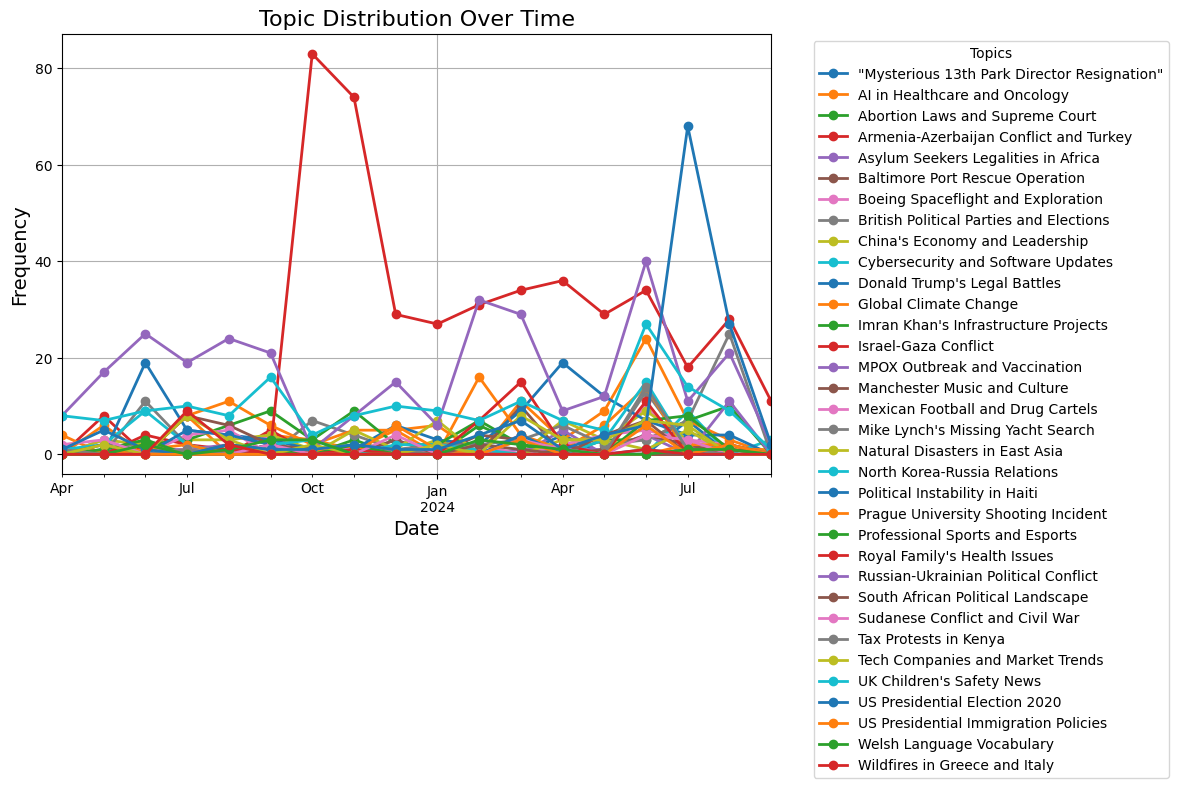

In [40]:
# Group by date and topic name to calculate frequency
topic_frequencies = (
    exploded_data_for_modeling
    .groupby(['Date', 'Assigned_Topic_Name'])
    .size()
    .reset_index(name='Frequency')
)

# Pivot the data for easier plotting
pivoted_data = topic_frequencies.pivot(index='Date', columns='Assigned_Topic_Name', values='Frequency').fillna(0)

# Plot the data
pivoted_data.plot(kind='line', figsize=(12, 7), marker='o', linewidth=2)

# Customize the plot
plt.title('Topic Distribution Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## Larger groups

Here, I am grouping the subtopics identified by BERTopic into larger groups for ease of analysis and interpretation.

In [41]:
topic_names

{-1: "UK Children's Safety News",
 0: 'Israel-Gaza Conflict',
 1: 'Russian-Ukrainian Political Conflict',
 2: 'US Presidential Election 2020',
 3: "Donald Trump's Legal Battles",
 4: 'AI in Healthcare and Oncology',
 5: 'Global Climate Change',
 6: "Imran Khan's Infrastructure Projects",
 7: "Mike Lynch's Missing Yacht Search",
 8: 'Tech Companies and Market Trends',
 9: "China's Economy and Leadership",
 10: 'North Korea-Russia Relations',
 11: "Royal Family's Health Issues",
 12: 'Manchester Music and Culture',
 13: 'British Political Parties and Elections',
 14: 'Mexican Football and Drug Cartels',
 15: 'Natural Disasters in East Asia',
 16: 'Professional Sports and Esports',
 17: 'Sudanese Conflict and Civil War',
 18: 'MPOX Outbreak and Vaccination',
 19: 'Boeing Spaceflight and Exploration',
 20: 'South African Political Landscape',
 21: 'Welsh Language Vocabulary',
 22: 'Tax Protests in Kenya',
 23: 'Political Instability in Haiti',
 24: 'Prague University Shooting Incident',
 2

In [4]:
# Grouping the subtopics
topic_groups = {
    "US-Related Politics": [2, 3, 26, 30, 31, 32],
    "UK Politics": [-1, 7, 13],
    "British culture": [11, 12, 21],
    "Russian War on Ukraine": [1],
    "Israeli-Gaza Conflict": [0],
    "Tech and Development": [4, 8, 19, 27],
    "Global Health and Climate Change Issues": [5, 15, 18, 28],
    "Russian Relations": [10],
    "Sports": [16],
    "Other Global News": [6, 9, 14, 17, 20, 22, 23, 24, 29], 
    "Armenia-Azerbaijan Conflict and Turkey": [25]
}

In [5]:
def assign_group(topic_id):
    """
    Assigns a group name based on the given topic ID by checking predefined topic groups.

    This function iterates over a dictionary called `topic_groups`, where each key is a group name and each value 
    is a list of topic IDs. If the provided topic_id is found in one of the groups, the corresponding group name is returned.
    If the topic_id is not found in any group, it returns "Other".

    Parameters:
        topic_id (Any): The identifier for a topic, which is compared against the lists in `topic_groups`.

    Returns:
        str: The name of the group to which the topic_id belongs, or "Other" if no match is found.
    """
    for group, ids in topic_groups.items():
        if topic_id in ids:
            return group
    return "Other"

exploded_data_for_modeling["Group"] = exploded_data_for_modeling["Assigned_Topic_ID"].apply(assign_group)

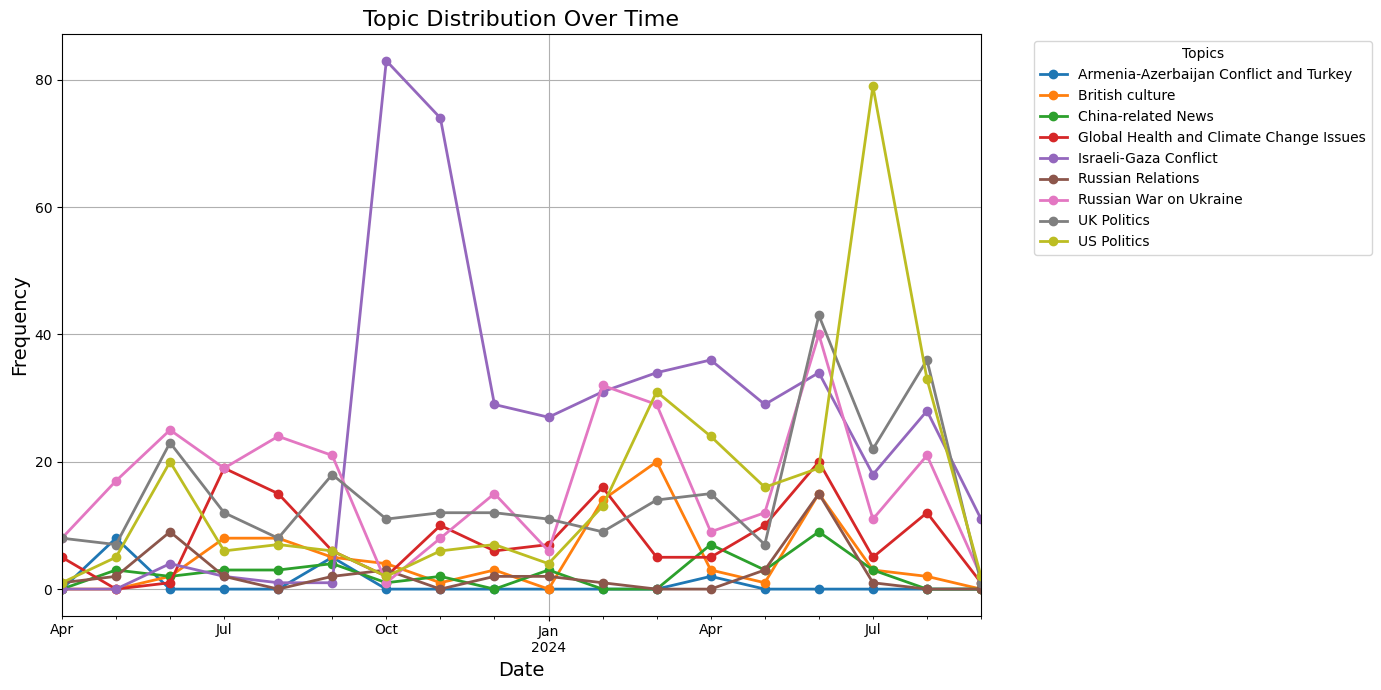

In [65]:
# Plotting the distribution of larger thematic topic groups
# Group by date and topic name to calculate frequency
topic_frequencies = (
    filtered_df
    .groupby(['Date', 'Group'])
    .size()
    .reset_index(name='Frequency')
)

pivoted_data = topic_frequencies.pivot(index='Date', columns='Group', values='Frequency').fillna(0)
pivoted_data = pivoted_data.loc[:, pivoted_data.sum(axis=0) > 0]

pivoted_data.plot(kind='line', figsize=(14, 7), marker='o', linewidth=2)
plt.title('Topic Distribution Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

## Sentiment Analysis

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np
from scipy.special import softmax
from tqdm import tqdm

In [7]:
exploded_data_for_modeling.to_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc/sentiment_scores.csv")


In [84]:
sentiments = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc/sentiment_scores.csv")

In [46]:
# Loading the sentiment model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Function to calculate sentiment scores for a single text
def get_sentiment_scores(text):
    """
    Calculates sentiment scores for a given text using a pre-trained sentiment analysis model.

    The function tokenizes the input text, feeds it into the model to obtain raw output, applies a softmax
    to convert the outputs into probability scores, and then maps these scores to their corresponding sentiment
    labels as defined in `config.id2label`.

    Parameters:
        text (str): The input text for which sentiment analysis is to be performed.

    Returns:
        dict: A dictionary mapping sentiment labels (e.g., "positive", "neutral", "negative") to their respective
              probability scores. In case of an error during processing, it prints an error message and returns
              a dictionary with sentiment values set to None.
    """
    try:
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        output = model(**encoded_input)
        scores = softmax(output[0][0].detach().numpy())
        return {config.id2label[i]: scores[i] for i in range(len(scores))}
    except Exception as e:
        print(f"Error processing text: {text[:50]}... - {e}")
        return {"positive": None, "neutral": None, "negative": None}

# Applying sentiment analysis to the dataframe
tqdm.pandas()
exploded_data_for_modeling['Sentiment_Scores'] = exploded_data_for_modeling['Processed_Chunks'].progress_apply(get_sentiment_scores)

# Extracting scores into separate columns
exploded_data_for_modeling['Positive_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('positive'))
exploded_data_for_modeling['Neutral_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('neutral'))
exploded_data_for_modeling['Negative_Score'] = exploded_data_for_modeling['Sentiment_Scores'].apply(lambda x: x.get('negative'))
exploded_data_for_modeling.drop(columns=['Sentiment_Scores'], inplace=True)

print(exploded_data_for_modeling.head())

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████| 2023/2023 [03:59<00:00,  8.45it/s]

   Year  Month                                             Chunks  \
0  2023  April  The group has begun a three-day official visit...   
1  2023  April  from the cathedral in the capital Budapest. We...   
2  2023  April  Sudan's army has accused its rival paramilitar...   
3  2023  April  Your live with BBC News. The European Space Ag...   
4  2023  April  physical disability to go to space and address...   

                                    Processed_Chunks  Assigned_Topic_ID  \
0  group begun three-day official visit Hungary, ...                  1   
1  cathedral capital Budapest. bring you, course,...                  1   
2  Sudan's army accused rival paramilitary rapid ...                 17   
3  News. European Space Agency's disabled astrona...                 -1   
4  physical disability space address issues hopef...                 -1   

                    Assigned_Topic_Name       Date                   Group  \
0  Russian-Ukrainian Political Conflict 2023-04-01  Russ

In [9]:
# Creating a column to store the final sentiment
exploded_data_for_modeling['Final_Sentiment'] = exploded_data_for_modeling[['Positive_Score', 'Neutral_Score', 'Negative_Score']].idxmax(axis=1)
exploded_data_for_modeling['Final_Sentiment_Score'] = exploded_data_for_modeling[['Positive_Score', 'Neutral_Score', 'Negative_Score']].max(axis=1)

In [10]:
exploded_data_for_modeling['Positive_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Positive_Score' else 0, axis=1)
exploded_data_for_modeling['Neutral_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Neutral_Score' else 0, axis=1)
exploded_data_for_modeling['Negative_Score'] = exploded_data_for_modeling.apply(lambda x: x['Final_Sentiment_Score'] if x['Final_Sentiment'] == 'Negative_Score' else 0, axis=1)

### Visualisation: Sentiment Proportions by topic groups

In [95]:
# Grouping the sentimnets and data by topic groups
grouped_sentiment = sentiments.groupby(['Group'])[['Positive_Score', 'Neutral_Score', 'Negative_Score']].mean().reset_index()

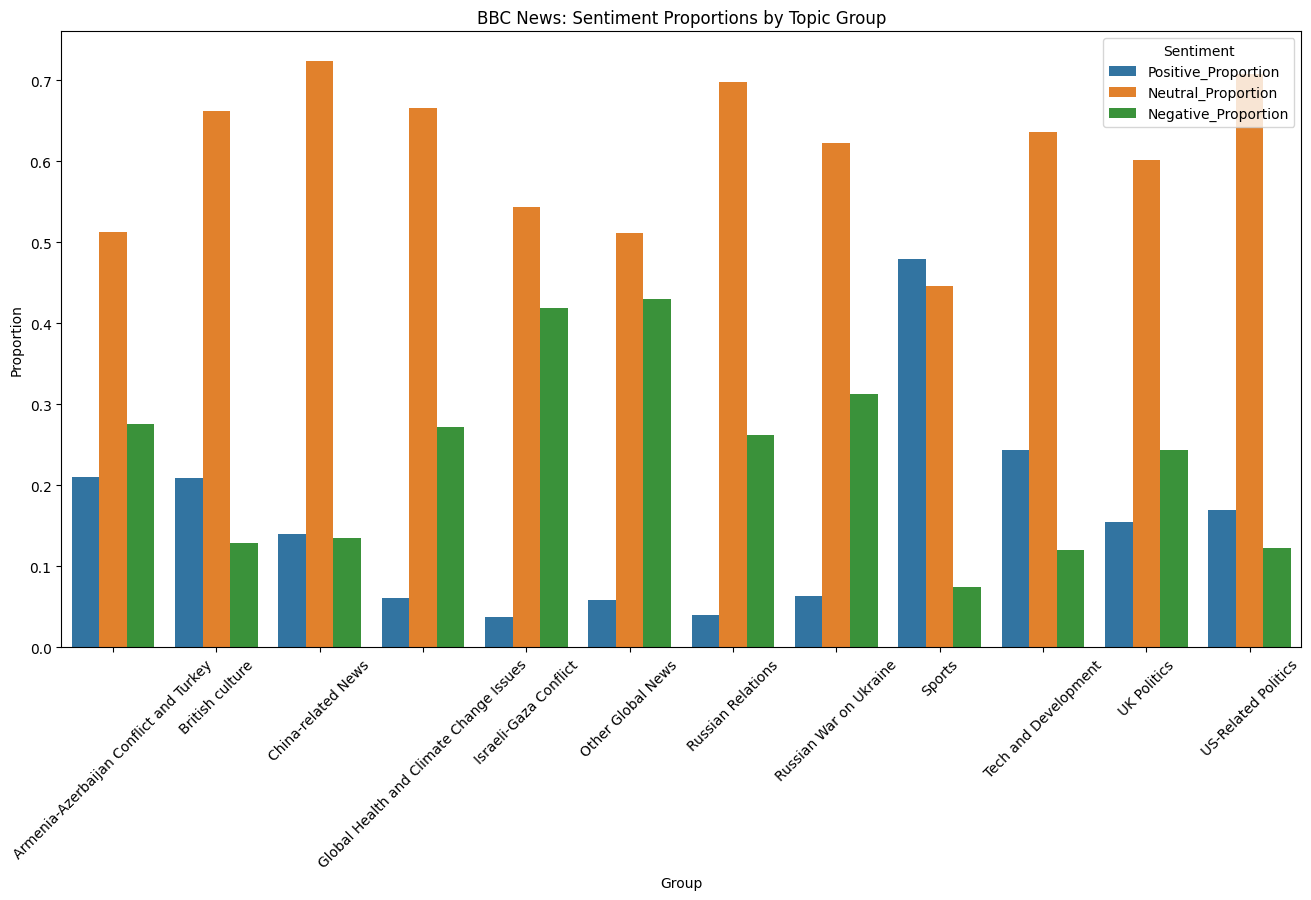

In [98]:
grouped_sentiment_long = grouped_sentiment.melt(
    id_vars=['Group'], 
    value_vars=['Positive_Score', 'Neutral_Score', 'Negative_Score'],
    var_name='Sentiment', 
    value_name='Proportion'
)
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(data=grouped_sentiment_long, x='Group', y='Proportion', ax=ax, hue='Sentiment')
plt.title('BBC News: Sentiment Proportions by Topic Group')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Sentiment')
plt.savefig("bbc_sentiment_distr.png", dpi=300, bbox_inches='tight')
plt.show()

### Summary Table: Sentiment Proportions by Group

In [21]:
selected_topics = ["Sports", "Russian War on Ukraine", "US-Related Politics", "UK Politics"]
filtered_data = grouped_sentiment[grouped_sentiment['Group'].isin(selected_topics)]

# Computing the averages
sentiment_averages = filtered_data.groupby('Group')[
    ['Positive_Proportion','Negative_Proportion']
].mean().reset_index()

news_by_metrics = sentiment_averages
news_by_metrics = news_by_metrics.rename(columns={
    'Positive_Proportion': 'Positive Sentiment',
    'Negative_Proportion': 'Negative Sentiment'
})

In [23]:
news_by_metrics.to_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc_summary_table.csv')

In [67]:
news_by_metrics

,Group,Positive Sentiment,Negative Sentiment
0,Russian War on Ukraine,0.064376,0.289184
1,Sports,0.446861,0.032204
2,UK Politics,0.153046,0.283409
3,US-Related Politics,0.137117,0.113357


## Emotion Analysis

In [1]:
exploded_data_for_modeling = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc/sentiment_scores.csv")

In [2]:
emotion_analysis_data = exploded_data_for_modeling.filter(['Date','Chunks','Processed_Chunks', 
                                                          'Assigned_Topic_ID', 'Assigned_Topic_Name',
                                                          'Group'], axis=1)

In [3]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Loading the emotion classifier from hugging face
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

def classify_emotions(text):
    """
    Classifies the emotions in a given text and extracts corresponding sentiment scores.

    This function uses a pre-trained emotion classifier to analyze the input text and returns a dictionary 
    mapping emotion labels (e.g., "joy", "anger", etc.) to their respective scores. The scores represent 
    the classifier's confidence in each emotion. In case of an error during processing, the function prints 
    an error message and returns an empty dictionary.

    Parameters:
        text (str): The input text to be analyzed for emotional content.

    Returns:
        dict: A dictionary where keys are emotion labels and values are their corresponding scores. 
              Returns an empty dictionary if an error occurs.
    """
    try:
        results = classifier(text)
        scores = {result['label']: result['score'] for result in results[0]}
        return scores
    except Exception as e:
        print(f"Error processing text: {text[:50]}... - {e}")
        return {}

tqdm.pandas()
emotion_analysis_data['Emotion_Scores'] = emotion_analysis_data['Processed_Chunks'].progress_apply(classify_emotions)

# Splitting the emotions disctionary inot different columns
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
for emotion in emotion_columns:
    emotion_analysis_data[f'{emotion}_score'] = emotion_analysis_data['Emotion_Scores'].apply(lambda x: x.get(emotion, None))
emotion_analysis_data.drop(columns=['Emotion_Scores'], inplace=True)

In [190]:
# Creating a column to store the final emotion (emotion with the strongest score)
emotion_analysis_data['Final_Emotion'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].idxmax(axis=1)
emotion_analysis_data['Final_Emotion_Score'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].max(axis=1)
emotion_analysis_data['Final_Emotion'] = emotion_analysis_data['Final_Emotion'].str.replace('_score', '', regex=False)

/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_68856/1450040514.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  emotion_analysis_data['Final_Emotion'] = emotion_analysis_data[['anger_score', 'disgust_score', 'fear_score', 'joy_score', 'neutral_score', 'sadness_score', 'surprise_score']].idxmax(axis=1)


### Visualisation: Emotion Proportion by Topic Group

In [49]:
# Creating quarters based on the date
emotion_analysis_data['Date'] = pd.to_datetime(emotion_analysis_data['Date'], errors='coerce')
emotion_analysis_data['Quarter'] = emotion_analysis_data['Date'].dt.to_period('Q')
emotion_analysis_data['Quarter'] = emotion_analysis_data['Quarter'].dt.start_time

In [4]:
# Grouping the emotion scores by Topic Groups
group_distribution = emotion_analysis_data.groupby(["Group"]).size().unstack()

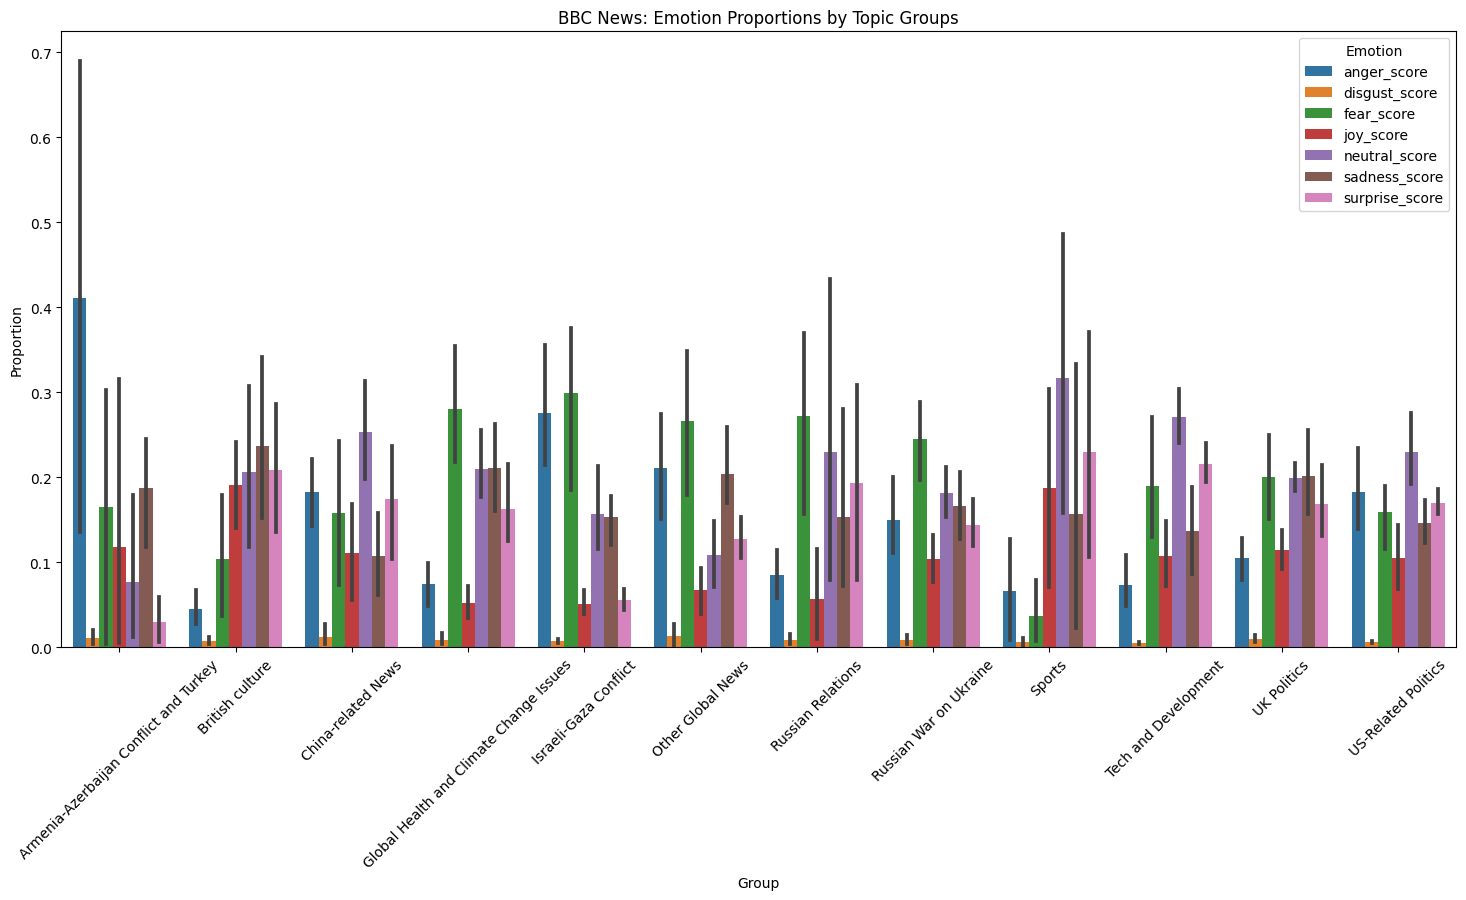

In [69]:
import seaborn as sns
# Plotting the bar chart of every topic group and emotion
grouped_emotion_long = grouped_emotion.melt(
    id_vars=['Group'], 
    value_vars=['anger_score', 'disgust_score', 'fear_score', 'joy_score', 
                'neutral_score', 'sadness_score', 'surprise_score'],
    var_name='Emotion', 
    value_name='Proportion'
)

fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data=grouped_emotion_long, x='Group', y='Proportion', ax=ax, hue='Emotion')
plt.title('BBC News: Emotion Proportions by Topic Groups')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Emotion')
plt.show()

In [70]:
# Keeping only the needed topics since the visualisation above is crowded
topics_to_keep = ['Sports', "UK Politics", "US-Related Politics", "Russian War on Ukraine"]
grouped_emotion_filtered = group_distribution.filter(["Russian War on Ukraine", "Sports", "UK Politics", "US-Related Politics"], axis = 1)

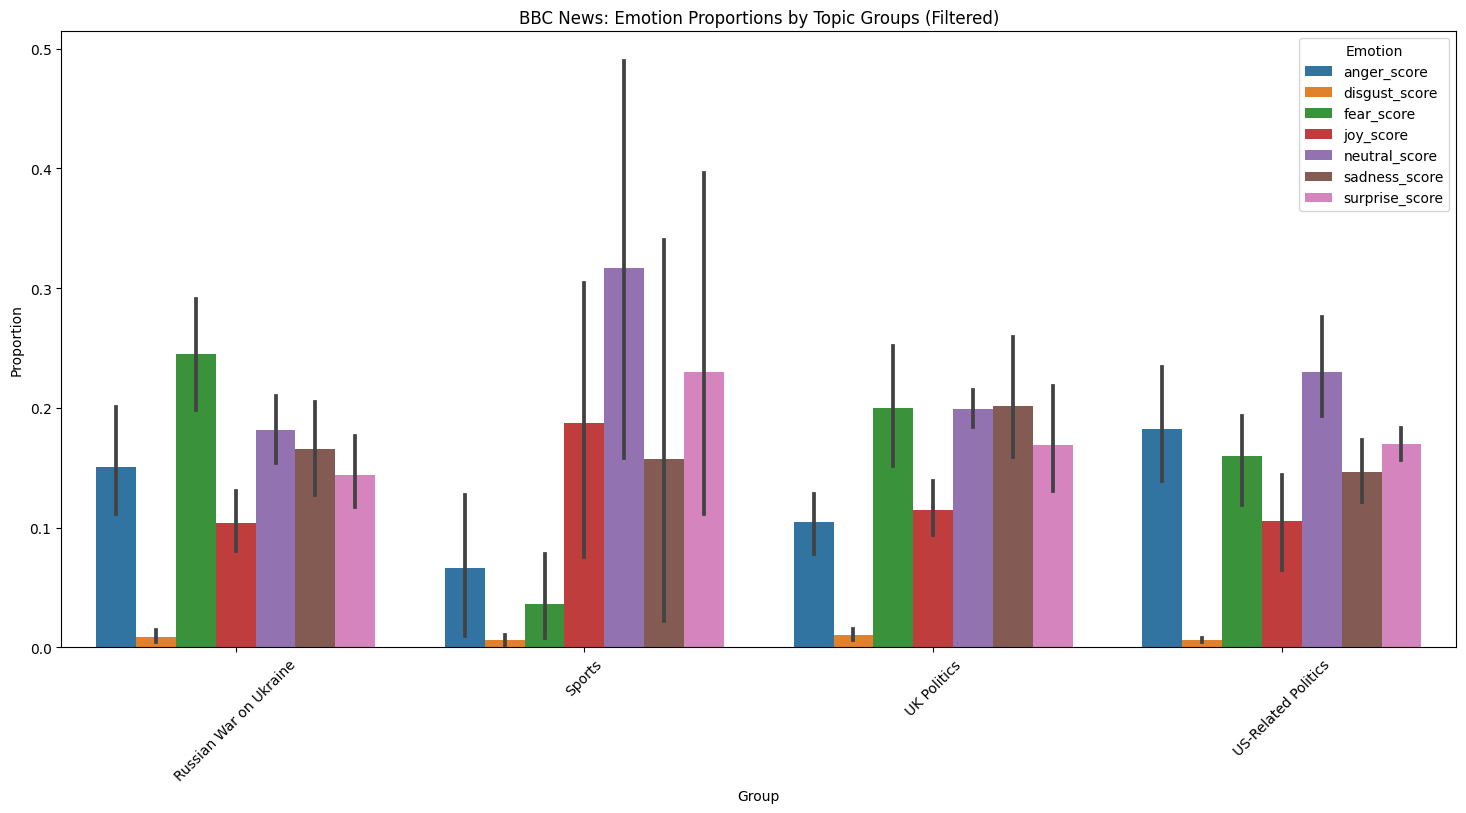

In [71]:
# Plotting the bar chart of every topic group and emotion
grouped_emotion_long = grouped_emotion_filtered.melt(
    id_vars=['Group'], 
    value_vars=['anger_score', 'disgust_score', 'fear_score', 'joy_score', 
                'neutral_score', 'sadness_score', 'surprise_score'],
    var_name='Emotion', 
    value_name='Proportion'
)

fig, ax = plt.subplots(figsize=(18, 8))
sns.barplot(data=grouped_emotion_long, x='Group', y='Proportion', ax=ax, hue='Emotion')
plt.title('BBC News: Emotion Proportions by Topic Groups (Filtered)')
plt.xlabel('Group')
plt.ylabel('Proportion')
plt.xticks(rotation=45, fontsize=10) 
plt.legend(title='Emotion')
plt.show()

### Emotion Analysis over time (Quarterly)

/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_16337/3644108307.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_emotion_filtered['Quarter'] = pd.to_datetime(grouped_emotion_filtered['Quarter'])
/var/folders/s5/nnqd5vlx3gxctyv9yyyny8j00000gn/T/ipykernel_16337/3644108307.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_emotion_filtered['Quarter_Label'] = grouped_emotion_filtered['Quarter'].dt.to_period('Q').astype(str).str.replace('Q', ' Q')


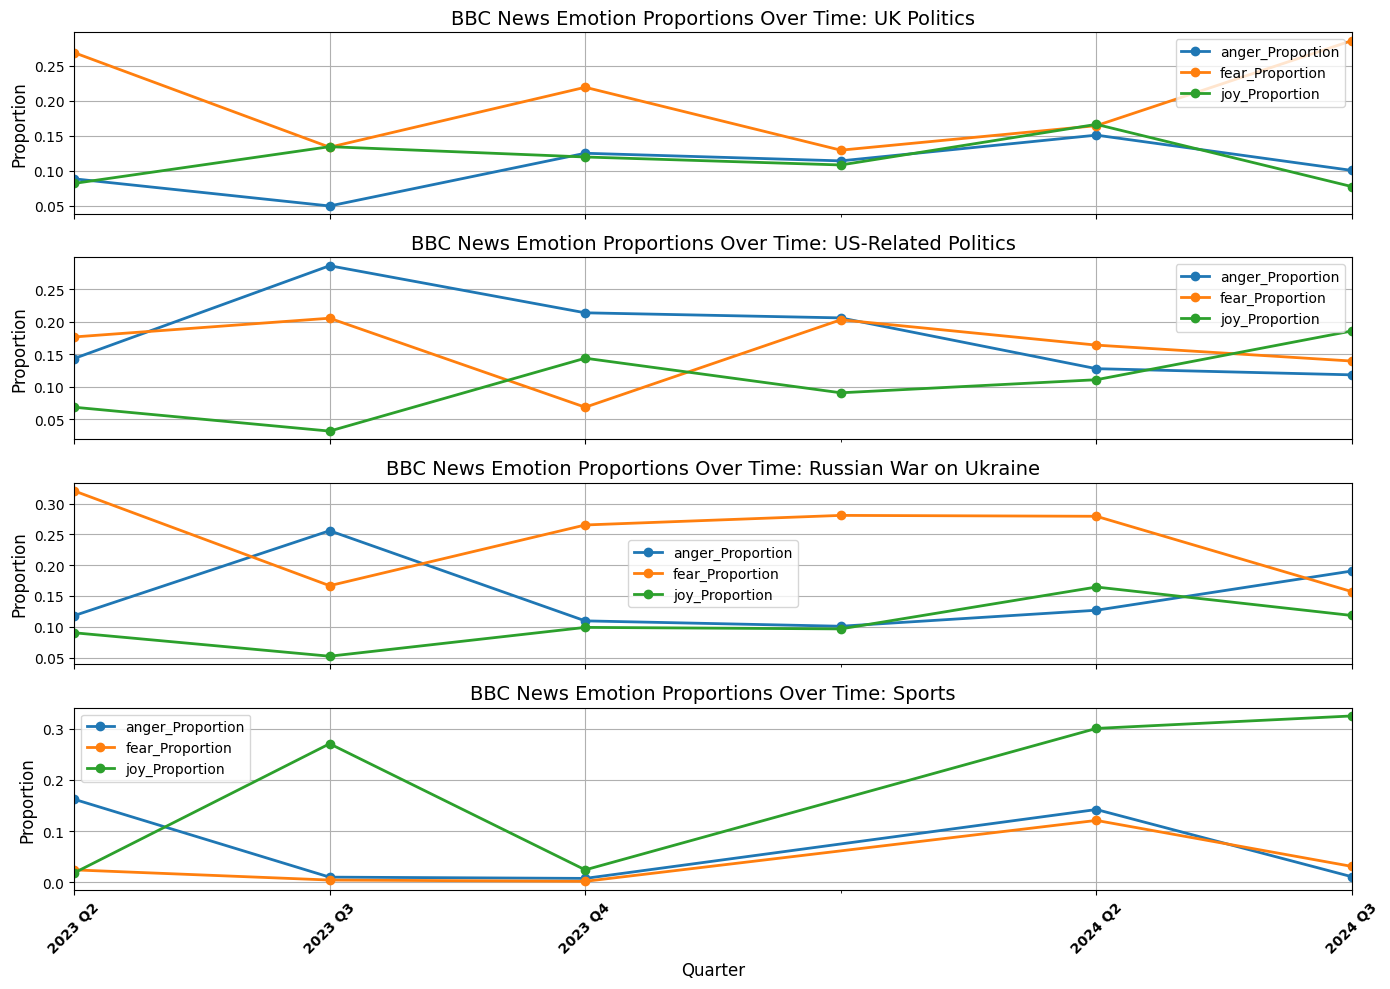

In [66]:
import matplotlib.dates as mdates
import pandas as pd

# Defining the topics and emotions of interest
topics = ['UK Politics', 'US-Related Politics', 'Russian War on Ukraine', 'Sports']
emotion_columns = ["anger_Proportion", "fear_Proportion", "joy_Proportion"]

# Ensure 'Quarter' is in datetime format
grouped_emotion_filtered['Quarter'] = pd.to_datetime(grouped_emotion_filtered['Quarter'])
grouped_emotion_filtered['Quarter_Label'] = grouped_emotion_filtered['Quarter'].dt.to_period('Q').astype(str).str.replace('Q', ' Q')

fig, axes = plt.subplots(len(topics), 1, figsize=(14, 10), sharex=True)
if len(topics) == 1:
    axes = [axes]

for i, topic in enumerate(topics):
    topic_data = grouped_emotion_filtered[grouped_emotion_filtered['Group'] == topic].copy()

    # Ensure 'Quarter' is the index
    topic_data.set_index('Quarter', inplace=True)

    if not topic_data.empty:
        topic_data[emotion_columns].plot(kind='line', ax=axes[i], marker='o', linewidth=2)

        # Set x-axis ticks and labels manually
        axes[i].set_xticks(topic_data.index)
        axes[i].set_xticklabels(topic_data['Quarter_Label'], rotation=45, fontsize=10, fontweight = 'bold')
    else:
        axes[i].text(0.5, 0.5, f"No data for {topic}", ha='center', va='center', fontsize=12, color='red')

    axes[i].set_title(f'BBC News Emotion Proportions Over Time: {topic}', fontsize=14)
    axes[i].set_ylabel('Proportion', fontsize=12)
    axes[i].grid(True)

plt.xlabel('Quarter', fontsize=12)
plt.tight_layout()
plt.show()

### Updating summary table with emotion scores

In [69]:
emotion_columns = ["fear_Proportion", "anger_Proportion", "joy_Proportion"]
emotion_averages = grouped_emotion_filtered.groupby("Group")[emotion_columns].mean().reset_index()
news_by_metrics = news_by_metrics.merge(emotion_averages, on="Group", how="left")

In [72]:
news_by_metrics.rename(columns={
    "fear_Proportion": "Fear Proportion",
    "anger_Proportion": "Anger Proportion",
    "joy_Proportion": "Joy Proportion",
}, inplace=True)

In [161]:
news_by_metrics

,Group,Positive Sentiment,Negative Sentiment,fear_Proportion_x,anger_Proportion_x,joy_Proportion_x
0,Russian War on Ukraine,0.064376,0.289184,0.223257,0.145196,0.106688
1,Sports,0.446861,0.032204,0.026268,0.057464,0.155575
2,UK Politics,0.153046,0.283409,0.248446,0.094833,0.111517
3,US-Related Politics,0.137117,0.113357,0.126751,0.215795,0.100364


## Perplexity Comparison between BBC News and News.by

In [109]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
torch.manual_seed(42)

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

def calculate_perplexity_first_1024(text):
    """Calculate perplexity using the first 1024 tokens of the text."""
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)["input_ids"]
    
    with torch.no_grad():
        outputs = model(input_ids=tokens, labels=tokens)
        loss = outputs.loss
        perplexity = torch.exp(loss)
    
    return perplexity.item()

In [123]:
# Applying the perplexity function to the selected topics in the dataframes
emotion_analysis_data.loc[
    emotion_analysis_data["Group"].isin(["Sports", "US-Related Politics", "Russian War on Ukraine", 
                                         "UK Politics"]), "Perplexity"
] = emotion_analysis_data["Chunks"].apply(calculate_perplexity_first_1024)

bel_emotion.loc[
    bel_emotion["Group"].isin(["Sports", "US-Related Politics", "Russian War on Ukraine", 
                               "Belarusian opposition"]), "Perplexity"
] = bel_emotion["Chunks"].apply(calculate_perplexity_first_1024)

In [146]:
max_perplexity_index = emotion_analysis_data['Perplexity'].idxmax()
emotion_analysis_data = emotion_analysis_data.drop(index=max_perplexity_index) # outlier

In [130]:
# Filtering out early data points
emotion_analysis_data = emotion_analysis_data[emotion_analysis_data["Date"] >= '2023-04']
bel_emotion = bel_emotion[bel_emotion["Date"] >= '2023-04']

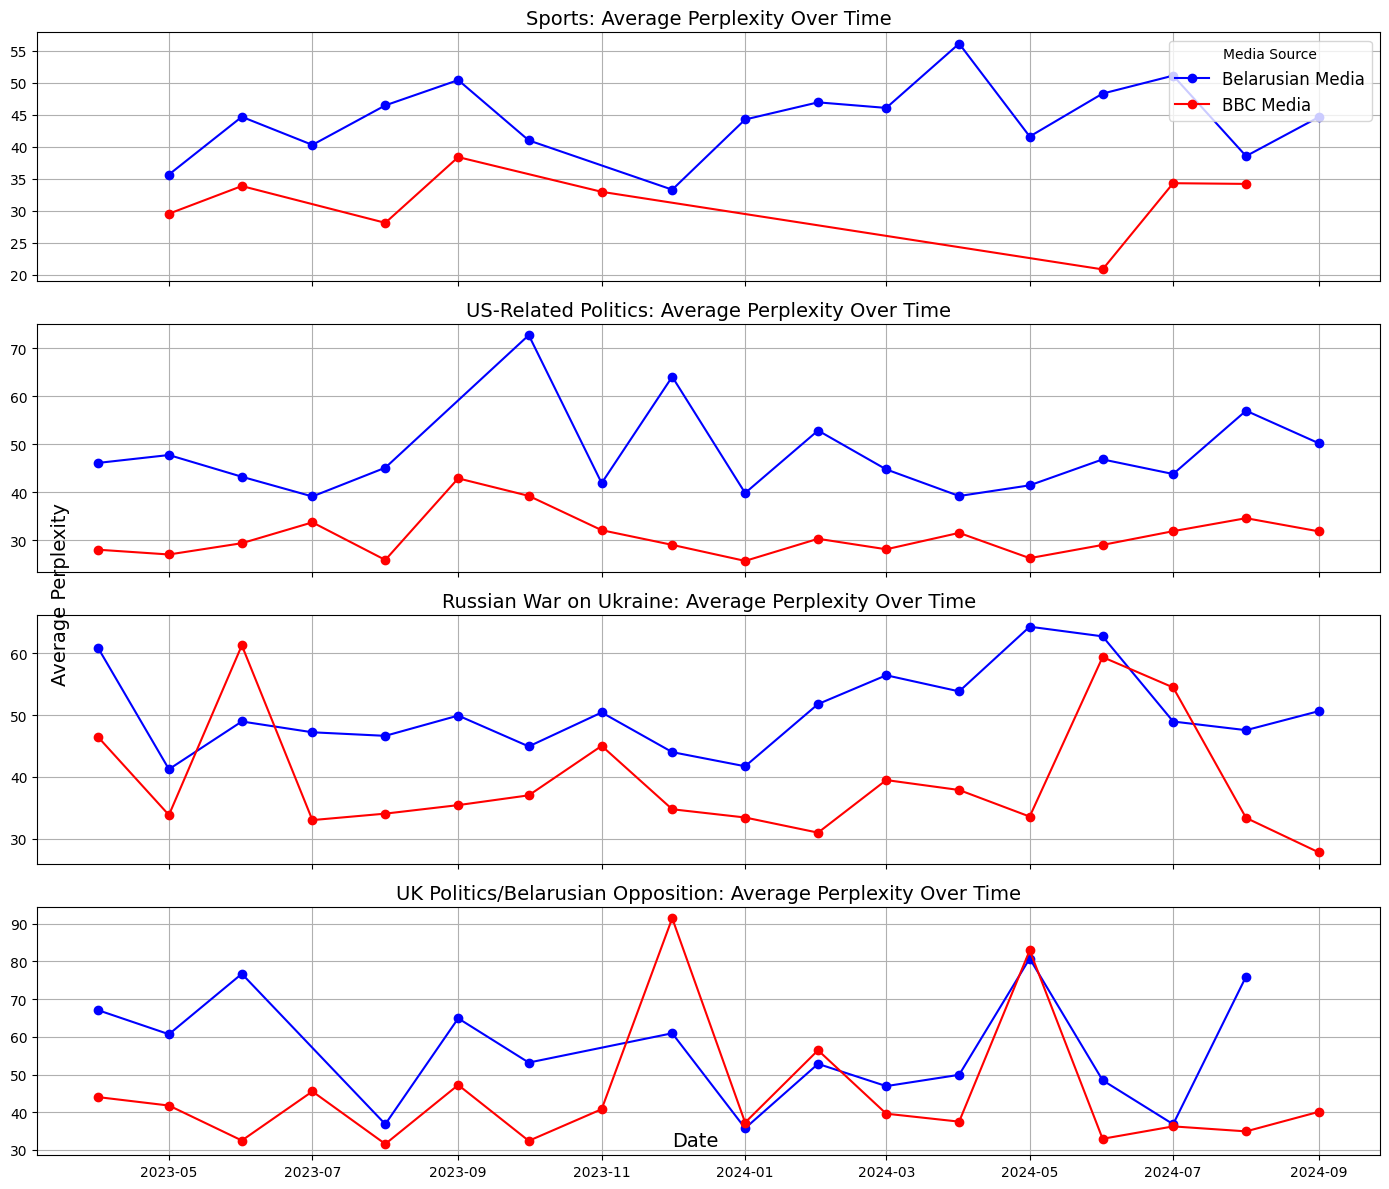

In [148]:
# Ensuring 'Date' columns are datetime
emotion_analysis_data["Date"] = pd.to_datetime(emotion_analysis_data["Date"])
bel_emotion["Date"] = pd.to_datetime(bel_emotion["Date"])
# Standardizing topic names for merging
bel_emotion["Group"] = bel_emotion["Group"].replace({"UK Politics (Belarusian Opposition)": "UK Politics/Belarusian Opposition"})
emotion_analysis_data["Group"] = emotion_analysis_data["Group"].replace({"UK Politics (Belarusian Opposition)": "UK Politics/Belarusian Opposition"})

topics = ["Sports", "US-Related Politics", "Russian War on Ukraine", "UK Politics/Belarusian Opposition"]
fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(14, 12))

for i, topic in enumerate(topics):
    ax = axes[i]

    bel_topic_df = bel_emotion[bel_emotion["Group"] == topic].groupby("Date")["Perplexity"].mean().reset_index()
    bbc_topic_df = emotion_analysis_data[emotion_analysis_data["Group"] == topic].groupby("Date")["Perplexity"].mean().reset_index()

    bel_topic_df = bel_topic_df.sort_values(by="Date")
    bbc_topic_df = bbc_topic_df.sort_values(by="Date")

    # Plotting Belarusian media
    ax.plot(
        bel_topic_df["Date"], bel_topic_df["Perplexity"], 
        label="Belarusian Media", color="blue", marker="o"
    )

    # Plotting BBC media
    ax.plot(
        bbc_topic_df["Date"], bbc_topic_df["Perplexity"], 
        label="BBC Media", color="red", marker="o"
    )

    ax.set_title(f"{topic}: Average Perplexity Over Time", fontsize=14)
    ax.grid(True)

fig.text(0.5, 0.04, "Date", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Average Perplexity", va="center", rotation="vertical", fontsize=14)
axes[0].legend(title="Media Source", fontsize=12, loc="upper right")
plt.tight_layout()
plt.savefig("perplexity_topic_comparisons.png", dpi=300, bbox_inches='tight')
plt.show()